In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Load the data
file_path = 'NEO Earth Close Approaches.csv'
neo_data = pd.read_csv(file_path)

# Data cleaning: Convert 'CA DistanceNominal (au)' to numeric for analysis
neo_data['CA DistanceNominal (au)'] = pd.to_numeric(neo_data['CA DistanceNominal (au)'], errors='coerce')
neo_data['V relative(km/s)'] = pd.to_numeric(neo_data['V relative(km/s)'], errors='coerce')

# Basic Statistics
print("Basic Statistics:")
print(neo_data.describe())


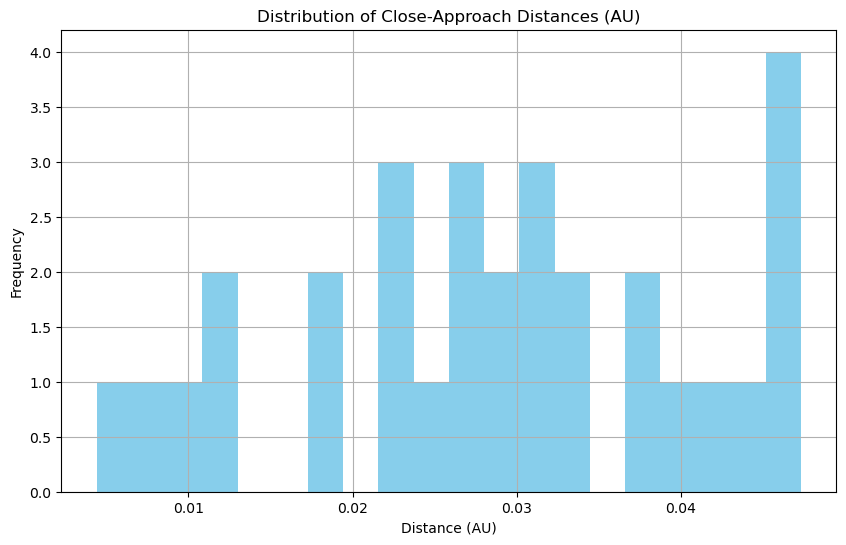

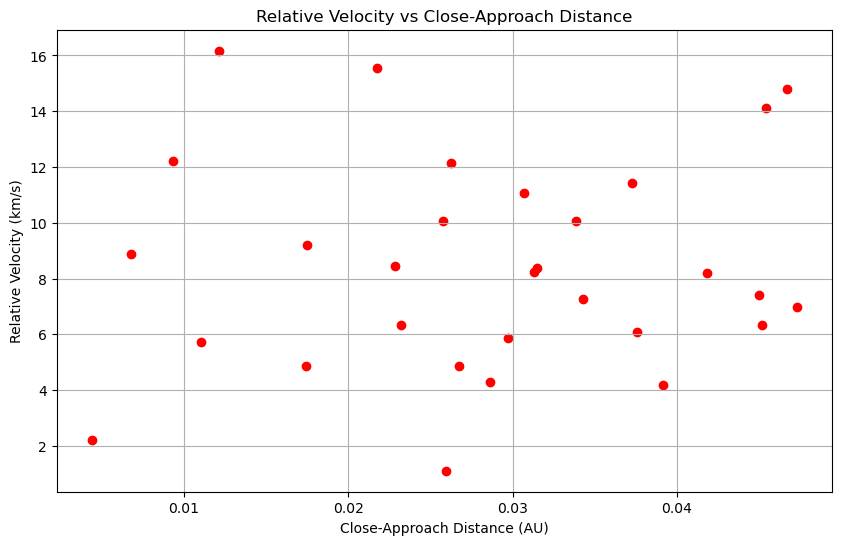

In [86]:
# Distribution of Close-Approach Distances
plt.figure(figsize=(10, 6))
plt.hist(neo_data['CA DistanceNominal (au)'].dropna(), bins=20, color='skyblue')
plt.title('Distribution of Close-Approach Distances (AU)')
plt.xlabel('Distance (AU)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Velocity vs Close-Approach Distance
plt.figure(figsize=(10, 6))
plt.scatter(neo_data['CA DistanceNominal (au)'], neo_data['V relative(km/s)'], color='red')
plt.title('Relative Velocity vs Close-Approach Distance')
plt.xlabel('Close-Approach Distance (AU)')
plt.ylabel('Relative Velocity (km/s)')
plt.grid(True)
plt.show()

In [87]:
# Handling missing values
neo_data = neo_data.dropna(subset=['CA DistanceNominal (au)', 'V relative(km/s)'])

# Identify potentially hazardous NEOs based on distance
risk_threshold_distance = 0.05  # Distance in AU
risk_threshold_velocity = 10  # Velocity in km/s
neo_data['Hazardous'] = ((neo_data['CA DistanceNominal (au)'] < risk_threshold_distance) & (neo_data['V relative(km/s)'] > risk_threshold_velocity))

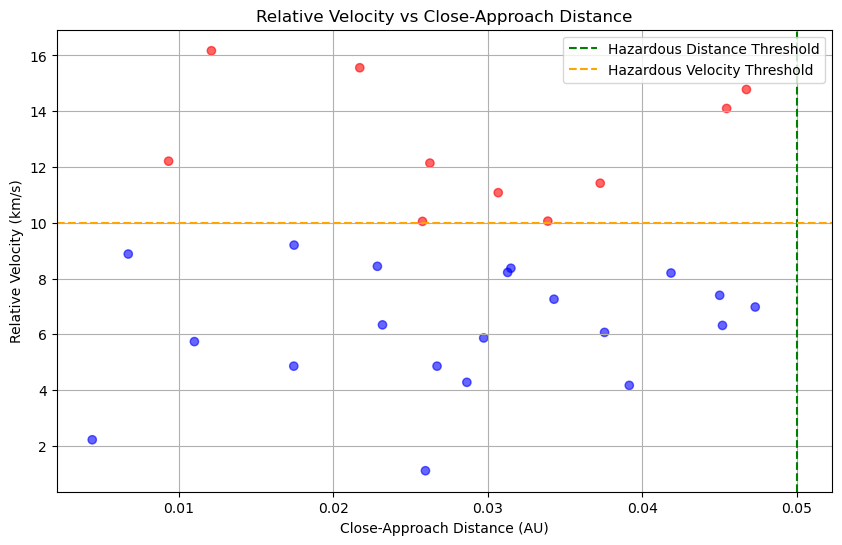

In [88]:
plt.figure(figsize=(10, 6))
plt.scatter(neo_data['CA DistanceNominal (au)'], neo_data['V relative(km/s)'], 
            c=neo_data['Hazardous'].map({True: 'red', False: 'blue'}), alpha=0.6)
plt.title('Relative Velocity vs Close-Approach Distance')
plt.xlabel('Close-Approach Distance (AU)')
plt.ylabel('Relative Velocity (km/s)')
plt.axvline(x=risk_threshold_distance, color='green', linestyle='--', label='Hazardous Distance Threshold')
plt.axhline(y=risk_threshold_velocity, color='orange', linestyle='--', label='Hazardous Velocity Threshold')
plt.legend()
plt.grid(True)
plt.show()

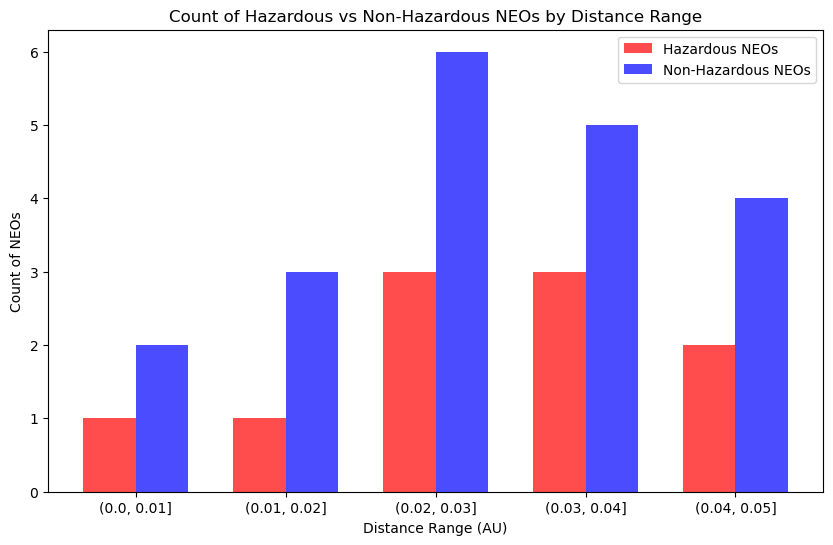

In [89]:
# Count hazardous NEOs within distance ranges
distance_bins = [0, 0.01, 0.02, 0.03, 0.04, 0.05]  # Define bins for distance
neo_data['Distance_Range'] = pd.cut(neo_data['CA DistanceNominal (au)'], bins=distance_bins)

# Count hazardous NEOs in each distance range
hazardous_counts = neo_data[neo_data['Hazardous']].groupby('Distance_Range', observed=True).size()
non_hazardous_counts = neo_data[~neo_data['Hazardous']].groupby('Distance_Range', observed=True).size()

plt.figure(figsize=(10, 6))
bar_width = 0.35
x = range(len(hazardous_counts))

plt.bar(x, hazardous_counts, width=bar_width, label='Hazardous NEOs', color='red', alpha=0.7)
plt.bar([p + bar_width for p in x], non_hazardous_counts, width=bar_width, label='Non-Hazardous NEOs', color='blue', alpha=0.7)

plt.title('Count of Hazardous vs Non-Hazardous NEOs by Distance Range')
plt.xlabel('Distance Range (AU)')
plt.ylabel('Count of NEOs')
plt.xticks([p + bar_width / 2 for p in x], hazardous_counts.index.astype(str))
plt.legend()
plt.show()

In [90]:
# Select features and target
X = neo_data[['CA DistanceNominal (au)', 'CA DistanceMinimum (au)', 'V relative(km/s)', 
              'V infinity(km/s)', 'H(mag)', 'Rarity']]
y = neo_data['Hazardous']  # Target

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Create a Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)


# Train the model
rf_classifier.fit(X_train, y_train)

# Make predictions
y_pred = rf_classifier.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

       False       1.00      1.00      1.00         8
        True       1.00      1.00      1.00         1

    accuracy                           1.00         9
   macro avg       1.00      1.00      1.00         9
weighted avg       1.00      1.00      1.00         9



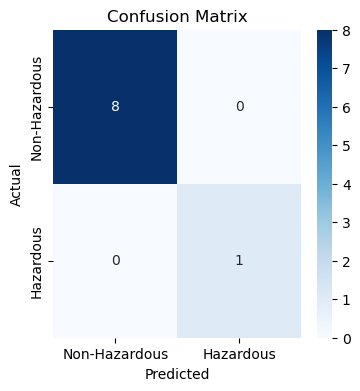

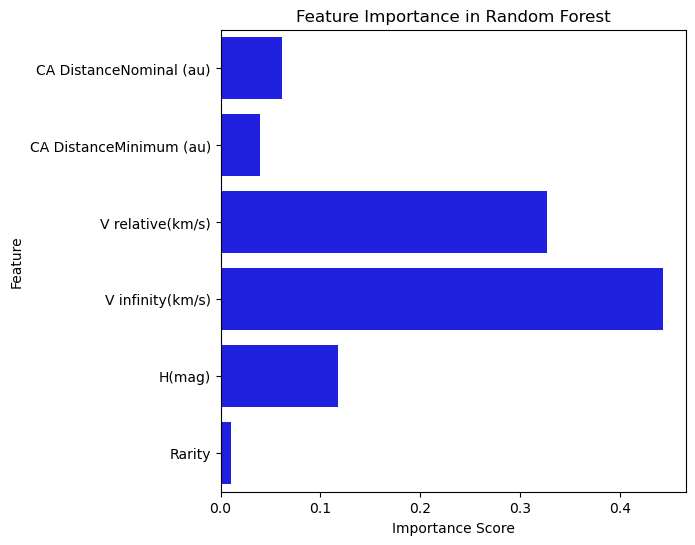

In [91]:
# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(4, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Hazardous', 'Hazardous'], yticklabels=['Non-Hazardous', 'Hazardous'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

# Get feature importances from the trained Random Forest classifier
importances = rf_classifier.feature_importances_
feature_names = X.columns

# Create a bar plot for feature importances
plt.figure(figsize=(6, 6))
sns.barplot(x=importances, y=feature_names,color='blue')
plt.title('Feature Importance in Random Forest')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.show()


c:\Users\kurup\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\kurup\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


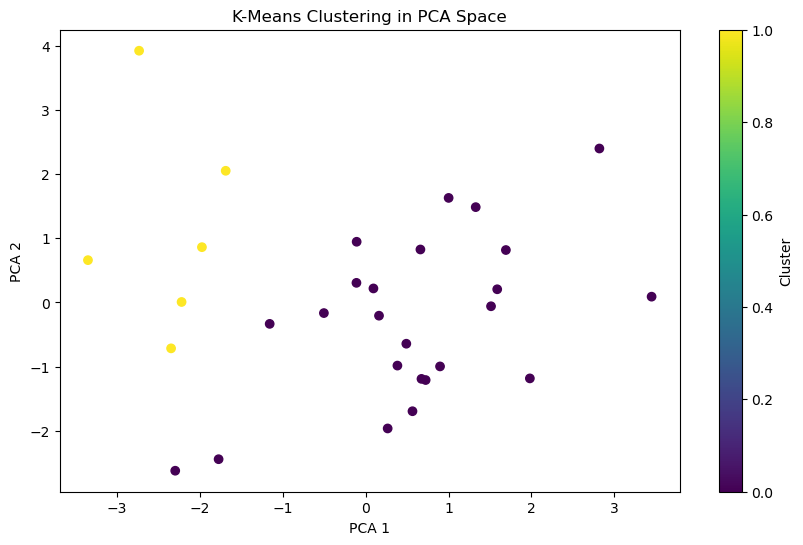

In [93]:
# Set the number of clusters from elbow method
n_clusters = 2
kmeans = KMeans(n_clusters=n_clusters, random_state=42)

# Fit the K-Means model
clusters = kmeans.fit_predict(X_scaled)

# Add cluster labels to the original dataframe
neo_data['Cluster'] = clusters

# applying PCA for accurate results

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Fit K-Means on PCA-reduced data
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters = kmeans.fit_predict(X_pca)

# Plotting the clusters in PCA space
plt.figure(figsize=(10, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='viridis', marker='o')
plt.title('K-Means Clustering in PCA Space')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.colorbar(label='Cluster')
plt.show()


Inertia (within-cluster sum of squares): 91.6538
Silhouette Score: 0.4045


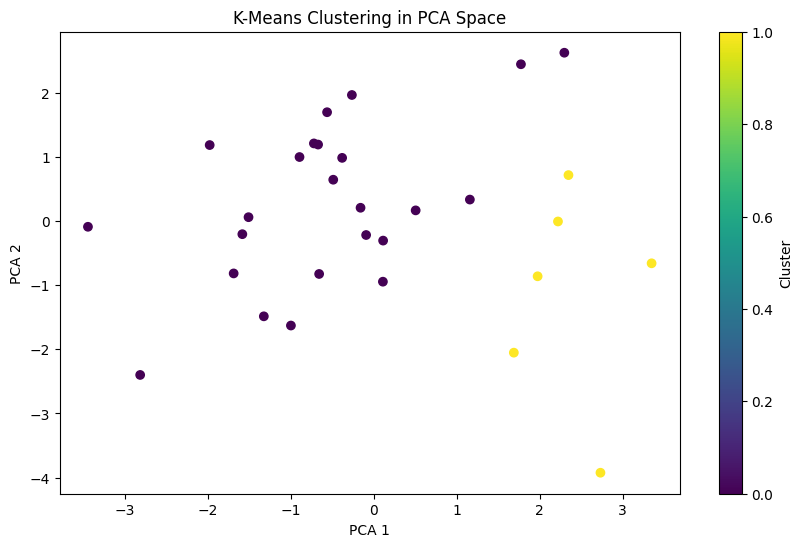

The model applied PCA for dimensionality reduction, followed by K-Means clustering. The Inertia metric, which represents within-cluster sum of squares, was 91.6538, indicating the compactness of clusters. Additionally, the Silhouette Score was 0.4045, showing the cohesion and separation of the clusters. These results suggest that the clusters formed are well-separated and compact.


In [5]:
# Import necessary libraries
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import pandas as pd
from sklearn.preprocessing import StandardScaler

file_path = 'NEO Earth Close Approaches.csv'
neo_data = pd.read_csv(file_path)

# Assuming X_scaled is your scaled dataset
X_cluster = neo_data[['CA DistanceNominal (au)', 'CA DistanceMinimum (au)', 
                      'V relative(km/s)', 'V infinity(km/s)', 
                      'H(mag)', 'Rarity']]

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_cluster)

# Step 1: Apply PCA to reduce dimensionality
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Step 2: Fit K-Means on PCA-reduced data
n_clusters = 2  # Define the number of clusters
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters = kmeans.fit_predict(X_pca)

# Step 3: Calculate evaluation metrics

# 3.1 Inertia (within-cluster sum of squares)
inertia = kmeans.inertia_

# 3.2 Silhouette Score
silhouette_avg = silhouette_score(X_pca, clusters)

# Step 4: Print the evaluation metrics
print(f"Inertia (within-cluster sum of squares): {inertia:.4f}")
print(f"Silhouette Score: {silhouette_avg:.4f}")

# Step 5: Visualize the clusters (optional but recommended for clarity)
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='viridis', marker='o')
plt.title('K-Means Clustering in PCA Space')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.colorbar(label='Cluster')
plt.show()

# Conclusion:
print("The model applied PCA for dimensionality reduction, followed by K-Means clustering. "
      "The Inertia metric, which represents within-cluster sum of squares, was {:.4f}, "
      "indicating the compactness of clusters. Additionally, the Silhouette Score was {:.4f}, "
      "showing the cohesion and separation of the clusters. These results suggest that "
      "the clusters formed are well-separated and compact.".format(inertia, silhouette_avg))
